**My Three Extensions:**
1.   Bidirectional LSTM implementation.
2.   GRU implementation.
3.   Using PyTorch's Dataset and DataLoader classes for loading the data.



**Design Choices and Performance Differences**

I chose datasets from three languages, English, Chinese and Portuguese. English data is from PyTorch's dataset torchtext with txt format, and other two datasets are from Universal Dependencies with conllu format. Therefore I need to be able to parse both formats in the PosData class, which is inherited from torch.utils.data.Dataset. Then in the training process, I implemented two types of models with different dimensions of word embedding to see the relation between model complexity and accuracy. I wrote train, plot, and evaluation parts as functions to use for convenience.

The results I got showed that the models for Chinese data performed not as good as other two languages, and models for Portuguese data performed best with accuracies higher from 91-94%, whereas models for Chinese has accuracies around 84-86% and models for English has around 86-89%. What I believe is that morphologically richer languages like Portuguese tend to perform better than morphologically less rich languages like Chinese, because it can be harder to recognize the part of speech of a word if the word carries less mophological information. It is also noticeable from the charts plotted that models for Chinese data converged much slower than the other two. 

Among the three types of RNN I implemented, bidirectional LSTM always perform better than the other two, and LSTM and GRU are quite similar in terms of accuracy. Since bidirectional LSTM goes from both directions and stores more information, it is resonable that this type of RNN performed better than uni-directional RNN models.

**The Relation Between Model Complexity and Accuracy**

In my implementations, I tried three types of RNN layers with different word embedding dimensions, 32 and 64, and it turned out that using 64 dimensional word embedding was making the accuracy on most test sets worse. Two exceptions were GRU implemented on English data, which improved the performance from 86.4% to 88% and LSTM implemented on Chinese, which increased the performance from 84.8-85.5%.

I guess it's because I doubled the number of dimensions which made the complexity much higher and it could be too detailed for the models to learn and leads to some extent of overfitting. I believe a small increase in the number of dimensions such as 40 dimension could make the models improve. The two exception showed that less complex layers like LSTM or GRU might see an increase in some cases and more complex layer like BiLSTM might be overfitting for most cases. It's a kind of trade-off between model complexity and word embedding dimensions.

In [1]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchtext.datasets import UDPOS
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
if torch.cuda.is_available():
    for i in range(torch.cuda.device_count()):
    print(torch.cuda.get_device_name(i))
else:
    print("No GPU available")

No GPU available


In [6]:
from conllu import parse_incr

class PosData(Dataset):
    def __init__(self, filepath):
        super().__init__()
        self.x = []
        self.y = []

        if ".txt" in filepath:
            with open(filepath, "r") as file:
                words = []
                labels = []
                for line in file.readlines():
                    if len(line) > 1:
                        word, tag, _ = line.split("\t")
                        words.append(word)
                        labels.append(tag)
                    else:
                        self.x.append(words)
                        self.y.append(labels)
                        words = []
                        labels = []

        elif ".conllu" in filepath:
            with open(filepath, "r") as file:
                sentences = parse_incr(file)
                sentences = [sentence for sentence in sentences if len(sentence) > 2]
                self.x = [[sent["form"] for sent in sentence] for sentence in sentences]
                self.y = [[sent["upos"] for sent in sentence] for sentence in sentences]

    def __getitem__(self, i):
        return self.x[i], self.y[i]

    def __len__(self):
        return len(self.x)

In [59]:
ud = UDPOS("train") # English UD data from torchtext
torch_train_path = "train/en-ud-v2/en-ud-tag.v2.train.txt"
torch_test_path = "train/en-ud-v2/en-ud-tag.v2.test.txt"

# Portuguese data from UD
portuguese_train_path = "/content/drive/MyDrive/ML/ud-treebanks-v2.7/UD_Portuguese-GSD/pt_gsd-ud-train.conllu"
portuguese_tets_path = "/content/drive/MyDrive/ML/ud-treebanks-v2.7/UD_Portuguese-GSD/pt_gsd-ud-test.conllu"

# Chinese data from UD
chinese_train_path = "/content/drive/MyDrive/ML/ud-treebanks-v2.7/UD_Chinese-GSDSimp/zh_gsdsimp-ud-train.conllu"
chinese_test_path = "/content/drive/MyDrive/ML/ud-treebanks-v2.7/UD_Chinese-GSDSimp/zh_gsdsimp-ud-test.conllu"

**Creating datasets**


In [60]:
torch_train = PosData(torch_train_path)
torch_test = PosData(torch_test_path)

portuguese_train = PosData(portuguese_train_path)
portuguese_test = PosData(portuguese_tets_path)

chinese_train = PosData(chinese_train_path)
chinese_test = PosData(chinese_test_path)

**Using English UD data from torchtext**

In [10]:
# create vocabulary for English data 

def collate(batch):
    data = [elem[0] for elem in batch]
    target = [elem[1] for elem in batch]
    return data, target

batch_size=50
torch_train_loader = DataLoader(dataset=torch_train, batch_size=50, 
                                shuffle=True, collate_fn=collate)
torch_test_loader = DataLoader(dataset=torch_test, batch_size=50, 
                               shuffle=True, collate_fn=collate)

tokens = {token for sents,_ in torch_train_loader for sent in sents for token in sent}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')
idx2token.append('<PAD>')
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for _,labels in torch_train_loader for tags in labels for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:15])
print(idx2tag)

['<UNK>', 'edit', 'determined', 'Whom', '713/853-6197', 'Network', 'encouragement', 'happily', 'endeavor', 'newborn', 'Orleans', 'Healing', '5,000', 'during', 'dispute']
['ADV', 'NUM', 'PUNCT', 'SYM', 'PROPN', 'X', 'DET', 'CCONJ', 'SCONJ', 'INTJ', 'ADJ', 'PRON', 'VERB', 'NOUN', 'AUX', 'PART', 'ADP', '<PAD>']


In [11]:
def pad_and_encode(sentences, labels):
  assert len(sentences)==len(labels)
  assert np.all([len(sentence)==len(tags) for sentence, tags in zip(sentences, labels)])
  max_sentence_length = np.max([len(sentence) for sentence in sentences]) # Find out how much to pad
  padded_sentences = torch.zeros(len(sentences), max_sentence_length,     # Create data structures with <PAD> as default
                                 dtype=torch.long)
  padded_sentences[:] = token2idx['<PAD>']
  padded_labels = torch.zeros(len(sentences), max_sentence_length, 
                              dtype=torch.long)
  padded_labels[:] = tag2idx['<PAD>']
  for i, (sentence, tags) in enumerate(zip(sentences, labels)):
    for j, token in enumerate(sentence):
      if token in token2idx.keys():
        padded_sentences[i, j] = token2idx[token]
      else:
        padded_sentences[i, j] = token2idx['<UNK>']
    for j, tag in enumerate(tags):
      padded_labels[i, j] = tag2idx[tag]
  return padded_sentences, padded_labels


In [12]:
torch_train_loader = [pad_and_encode(sents, labels) for sents, labels in torch_train_loader]
torch_test_loader = [pad_and_encode(sents, labels) for sents, labels in torch_test_loader]

**Create three models:** 
*   **LSTM (Baseline)**
*   **Bidirectional LSTM**
*   **GRU**







In [13]:
class LSTMTagger(nn.Module):
    """
    Baseline model
    """
    def __init__(self, word_embedding_dim, lstm_hidden_dim, vocabulary_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.lstm_hidden_dim_ = lstm_hidden_dim
        self.vocabulary_size_ = vocabulary_size
        self.tagset_size_ = tagset_size
        self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                         embedding_dim=word_embedding_dim,
                                         padding_idx=token2idx['<PAD>'])
        self._lstm = nn.LSTM(input_size=word_embedding_dim,
                         hidden_size=lstm_hidden_dim,
                         batch_first=True)
        self._fc = nn.Linear(lstm_hidden_dim, tagset_size)
        self._softmax = nn.LogSoftmax(dim=1)

        self.training_loss_ = list()
        self.training_accuracy_ = list()

        if torch.cuda.is_available(): 
            self.cuda()

    def forward(self, padded_sentences):
        """
        :param padded_sentences: [batch_size, max_sentence_len]
        :return: [batch_size, max_sentence_length, tagset_size]
        """
        batch_size, max_sentence_length = padded_sentences.size()
        embedded_sentences = self._word_embedding(padded_sentences)

        sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)
        sentence_lengths = sentence_lengths.long().cpu()
        
        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted=False)
        lstm_out, _ = self._lstm(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        X = X.contiguous().view(-1, X.shape[2])

        tag_space = self._fc(X)
        tag_scores = self._softmax(tag_space)
        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


class BiLSTMTagger(nn.Module):
    def __init__(self, word_embedding_dim, lstm_hidden_dim, vocabulary_size, tagset_size):
        """
        Bidirectinal LSTM model
        """
        super(BiLSTMTagger, self).__init__()
        self.lstm_hidden_dim_ = lstm_hidden_dim
        self.vocabulary_size_ = vocabulary_size
        self.tagset_size_ = tagset_size
        self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size,
                                         embedding_dim=word_embedding_dim,
                                         padding_idx=token2idx['<PAD>'])
        self._lstm = nn.LSTM(input_size=word_embedding_dim,
                         hidden_size=lstm_hidden_dim,
                         bidirectional=True,
                         batch_first=True, num_layers=2)
        self._fc = nn.Linear(lstm_hidden_dim * 2, tagset_size)
        self._softmax = nn.LogSoftmax(dim=1)

        self.training_loss_ = list()
        self.training_accuracy_ = list()

        if torch.cuda.is_available(): 
            self.cuda()

    def forward(self, padded_sentences):
        """
        :param padded_sentences: [batch_size, max_sentence_len]
        :return: [batch_size, max_sentence_length, tagset_size]
        """
        batch_size, max_sentence_length = padded_sentences.size()
        embedded_sentences = self._word_embedding(padded_sentences)

        sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)
        sentence_lengths = sentence_lengths.long().cpu()
        
        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted=False)
        lstm_out, _ = self._lstm(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        X = X.contiguous().view(-1, X.shape[2])

        tag_space = self._fc(X)
        tag_scores = self._softmax(tag_space)
        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)


class GRUTagger(nn.Module):
    def __init__(self, word_embedding_dim, vocabulary_size, gru_hidden_dim, tagset_size):
        """
        Gated Recurrent Unit model
        """
        super().__init__()
        self.gru_hidden_dim = gru_hidden_dim                                    
        self.vocabulary_size_ = vocabulary_size
        self.tagset_size_ = tagset_size

        self._word_embedding = nn.Embedding(num_embeddings=vocabulary_size, 
                                      embedding_dim=word_embedding_dim,
                                      padding_idx=token2idx['<PAD>'])
        self._gru = nn.GRU(input_size=word_embedding_dim, 
                          hidden_size=gru_hidden_dim, 
                          batch_first=True)
        self._fc = nn.Linear(gru_hidden_dim, tagset_size)                           
        self._softmax = nn.LogSoftmax(dim=1)

        self.training_loss_ = list()                                               
        self.training_accuracy_ = list()
      
        if torch.cuda.is_available():
            self.cuda()
    
    def forward(self, padded_sentences):
        batch_size, max_sentence_length = padded_sentences.size()
        embedded_sentences = self._word_embedding(padded_sentences)

        sentence_lengths = (padded_sentences!=token2idx['<PAD>']).sum(dim=1)
        sentence_lengths = sentence_lengths.long().cpu()
        
        X = nn.utils.rnn.pack_padded_sequence(embedded_sentences, sentence_lengths,
                                              batch_first=True, enforce_sorted=False)
        gru_out, _ = self._gru(X)
        X, _ = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)

        X = X.contiguous().view(-1, X.shape[2])

        tag_space = self._fc(X)
        tag_scores = self._softmax(tag_space)
        return tag_scores.view(batch_size, max_sentence_length, self.tagset_size_)

In [14]:
# model2 has more word embedding dimensions
lstm = LSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                  tagset_size=len(tag2idx)-1)

lstm2 = LSTMTagger(word_embedding_dim=64, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                  tagset_size=len(tag2idx)-1)


bilstm = BiLSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)
bilstm2 = BiLSTMTagger(word_embedding_dim=64, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)


gru = GRUTagger(word_embedding_dim=32, gru_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)
gru2 = GRUTagger(word_embedding_dim=64, gru_hidden_dim=64, vocabulary_size=len(token2idx),
                       tagset_size=len(tag2idx)-1)


**Functions to use for training, visualization and evaluation**

In [15]:
# define a model-training function for future use
def train(model, epoch, train_loader):
    loss_function = nn.NLLLoss(ignore_index=tag2idx['<PAD>'])
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    batch_size = 50

    for epoch in range(epoch):
        with tqdm(train_loader, total=len(train_loader)//batch_size+1, 
                  unit="batch", desc="Epoch %i" % epoch) as batches:
            for X_batch, y_batch in batches:
                if torch.cuda.is_available():
                    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

                model.zero_grad()
                scores = model(X_batch)

                loss = loss_function(scores.view(-1, model.tagset_size_), y_batch.view(-1))
                loss.backward()
                optimizer.step()
                
                predictions = scores.argmax(dim=2, keepdim=True).squeeze()              # Calculate the batch training accuracy
                mask = y_batch!=tag2idx['<PAD>']                                   # Create a mask for ignoring <PAD> in the targets
                correct = (predictions[mask] == y_batch[mask]).sum().item()            # Item pulls the value from the GPU automatically (if needed)
                accuracy = correct / mask.sum().item()*100
                model.training_accuracy_.append(accuracy)                               # Save the accuracy for plotting
                model.training_loss_.append(loss.item())
                batches.set_postfix(loss=loss.item(), accuracy=accuracy)

In [16]:
def pltshow(model):
    """
    plot the training process of a model
    """
    fig = plt.figure(figsize=(6, 4))
    ax = plt.subplot()
    ax.set_title("Plot for the (hopefully) decreasing loss over epochs")
    ax.plot(model.training_loss_, 'b-')
    ax.set_ylabel("Training Loss", color='b')
    ax.set_xlabel("Epoch")
    ax.tick_params(axis='y', labelcolor='b')
    ax = ax.twinx()
    ax.plot(model.training_accuracy_, 'r-')
    ax.set_ylabel("Accuracy [%]", color='r')
    ax.tick_params(axis='y', labelcolor='r')
    a = list(ax.axis())
    a[2] = 0
    a[3] = 100
    ax.axis(a)
    t = np.arange(0, len(model.training_accuracy_), len(torch_train_loader)//batch_size+1)
    ax.set_xticks(ticks=t)
    ax.set_xticklabels(labels=np.arange(len(t)))
    fig.tight_layout()
    plt.show()

In [17]:
def eval(model, test_loader):
    """
    For model evaluation on the test set
    """
    with torch.no_grad():                                                           
        n_correct = 0
        n_total = 0
        for X_batch, y_batch in test_loader:
            if torch.cuda.is_available():
                X_batch, y_batch = X_batch.cuda(), y_batch.cuda()

            scores = model(X_batch)
            predictions = scores.argmax(dim=2, keepdim=True).squeeze()
            mask = y_batch!=tag2idx['<PAD>']
            n_correct += (predictions[mask] == y_batch[mask]).sum().item()
            n_total += mask.sum().item()
    print("Test accuracy %.1f%%" % (100*n_correct/n_total))

Baseline LSTM model training and evaluation on English data

In [18]:
train(model=lstm, epoch=5, train_loader=torch_train_loader)

Epoch 0: 251batch [00:17, 14.14batch/s, accuracy=85.7, loss=0.444]
Epoch 1: 251batch [00:17, 14.60batch/s, accuracy=92, loss=0.261]
Epoch 2: 251batch [00:17, 14.73batch/s, accuracy=94.3, loss=0.172]
Epoch 3: 251batch [00:17, 14.42batch/s, accuracy=95.9, loss=0.122]
Epoch 4: 251batch [00:16, 14.88batch/s, accuracy=97.4, loss=0.0849]


In [19]:
train(model=lstm2, epoch=5, train_loader=torch_train_loader)

Epoch 0: 251batch [00:19, 12.64batch/s, accuracy=88.7, loss=0.356]
Epoch 1: 251batch [00:19, 13.02batch/s, accuracy=94.1, loss=0.191]
Epoch 2: 251batch [00:18, 13.21batch/s, accuracy=95.8, loss=0.112]
Epoch 3: 251batch [00:18, 13.44batch/s, accuracy=97.1, loss=0.0858]
Epoch 4: 251batch [00:19, 12.97batch/s, accuracy=97.4, loss=0.0695]


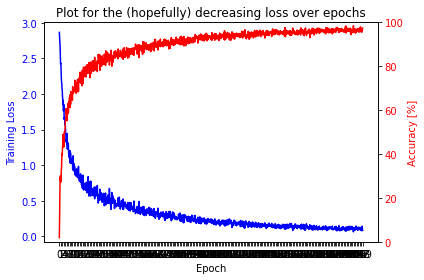

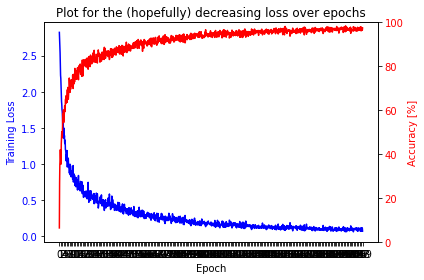

In [20]:
pltshow(lstm)
pltshow(lstm2)

In [21]:
eval(model=lstm, test_loader=torch_test_loader)
eval(model=lstm2, test_loader=torch_test_loader)

Test accuracy 86.7%
Test accuracy 86.7%


Bidirectional LSTM model training and evaluation on English data

In [22]:
train(model=bilstm, epoch=5, train_loader=torch_train_loader)

Epoch 0: 251batch [00:52,  4.81batch/s, accuracy=89.4, loss=0.323]
Epoch 1: 251batch [00:50,  4.93batch/s, accuracy=95.8, loss=0.13]
Epoch 2: 251batch [00:51,  4.87batch/s, accuracy=97.1, loss=0.0672]
Epoch 3: 251batch [00:51,  4.86batch/s, accuracy=98.6, loss=0.0421]
Epoch 4: 251batch [00:51,  4.90batch/s, accuracy=99.5, loss=0.024]


In [23]:
train(model=bilstm2, epoch=5, train_loader=torch_train_loader)

Epoch 0: 251batch [00:54,  4.61batch/s, accuracy=89.6, loss=0.298]
Epoch 1: 251batch [00:53,  4.67batch/s, accuracy=96.2, loss=0.104]
Epoch 2: 251batch [00:53,  4.69batch/s, accuracy=97.9, loss=0.0569]
Epoch 3: 251batch [00:54,  4.64batch/s, accuracy=98.8, loss=0.0367]
Epoch 4: 251batch [00:53,  4.65batch/s, accuracy=99.4, loss=0.0172]


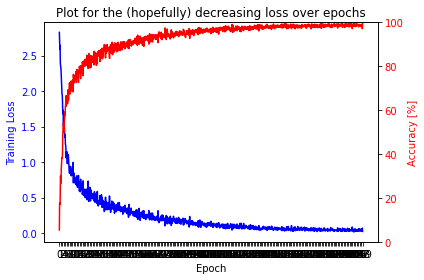

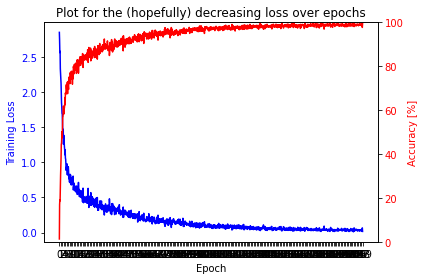

In [24]:
pltshow(bilstm)
pltshow(bilstm2)

In [25]:
eval(bilstm, test_loader=torch_test_loader)
eval(bilstm2, test_loader=torch_test_loader)

Test accuracy 89.7%
Test accuracy 89.2%


GRU model training and evaluation on English data

In [26]:
train(model=gru, epoch=5, train_loader=torch_train_loader)

Epoch 0: 251batch [00:16, 15.14batch/s, accuracy=84.9, loss=0.474]
Epoch 1: 251batch [00:15, 16.00batch/s, accuracy=92, loss=0.265]
Epoch 2: 251batch [00:16, 15.36batch/s, accuracy=94, loss=0.159]
Epoch 3: 251batch [00:16, 15.13batch/s, accuracy=96.1, loss=0.113]
Epoch 4: 251batch [00:16, 15.25batch/s, accuracy=96.1, loss=0.0942]


In [27]:
train(model=gru2, epoch=5, train_loader=torch_train_loader)

Epoch 0: 251batch [00:19, 12.99batch/s, accuracy=87.2, loss=0.411]
Epoch 1: 251batch [00:18, 13.94batch/s, accuracy=93.2, loss=0.205]
Epoch 2: 251batch [00:18, 13.72batch/s, accuracy=95.8, loss=0.127]
Epoch 3: 251batch [00:17, 13.95batch/s, accuracy=96.1, loss=0.0989]
Epoch 4: 251batch [00:17, 14.20batch/s, accuracy=97.1, loss=0.0711]


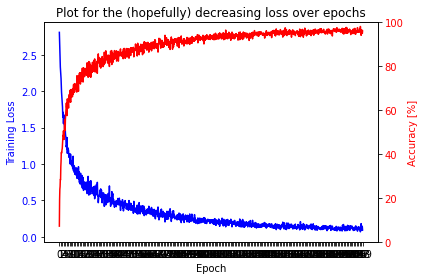

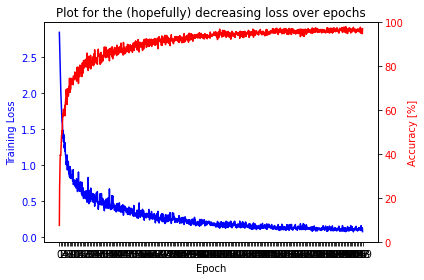

In [28]:
pltshow(gru)
pltshow(gru2)

In [29]:
eval(model=gru, test_loader=torch_test_loader)
eval(model=gru2, test_loader=torch_test_loader)

Test accuracy 86.4%
Test accuracy 88.0%


**Using UD Chinese data**

In [38]:
batch_size=50
chinese_train_loader = DataLoader(dataset=chinese_train, batch_size=50, 
                                  shuffle=True, collate_fn=collate)
chinese_test_loader = DataLoader(dataset=chinese_test, batch_size=50, 
                                 shuffle=True, collate_fn=collate)

# create vocabulary for Chinese data 
tokens = {token for sents,_ in chinese_train_loader for sent in sents for token in sent}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')
idx2token.append('<PAD>')
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for _,labels in chinese_train_loader for tags in labels for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:15])
print(idx2tag)

['<UNK>', '决然', '颉', '亲情', '陵寝', '建御雷', '交代', '平阳', '配角', '几内亚', '上手', '氯金酸', '大学', '霍伊尔', '湖畔']
['AUX', 'ADV', 'NUM', 'PUNCT', 'X', 'SYM', 'CCONJ', 'DET', 'ADJ', 'PRON', 'VERB', 'NOUN', 'PROPN', 'PART', 'ADP', '<PAD>']


In [39]:
chinese_train_loader = [pad_and_encode(sents, labels) for sents, labels in chinese_train_loader]
chinese_test_loader = [pad_and_encode(sents, labels) for sents, labels in chinese_test_loader]

In [40]:
# create new models for Chinese data
lstmc = LSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                  tagset_size=len(tag2idx)-1)

lstmc2 = LSTMTagger(word_embedding_dim=64, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                  tagset_size=len(tag2idx)-1)


bilstmc = BiLSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)
bilstmc2 = BiLSTMTagger(word_embedding_dim=64, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)


gruc = GRUTagger(word_embedding_dim=32, gru_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)
gruc2 = GRUTagger(word_embedding_dim=64, gru_hidden_dim=64, vocabulary_size=len(token2idx),
                       tagset_size=len(tag2idx)-1)

Baseline LSTM training on Chinese data

In [41]:
train(model=lstmc, epoch=5, train_loader=chinese_train_loader)
train(lstmc2, 5, chinese_train_loader)

Epoch 0: 80batch [00:07, 10.04batch/s, accuracy=70.9, loss=0.898]
Epoch 1: 80batch [00:07, 10.33batch/s, accuracy=82.4, loss=0.546]
Epoch 2: 80batch [00:07, 10.44batch/s, accuracy=88, loss=0.369]
Epoch 3: 80batch [00:07, 10.34batch/s, accuracy=91.2, loss=0.26]
Epoch 4: 80batch [00:07, 10.84batch/s, accuracy=93.8, loss=0.195]
Epoch 0:  50%|█████     | 1/2 [00:00<00:00,  9.26batch/s, accuracy=6.2, loss=2.71]

Epoch 0: 80batch [00:08,  9.42batch/s, accuracy=75, loss=0.755]
Epoch 1: 80batch [00:08,  9.56batch/s, accuracy=86.1, loss=0.424]
Epoch 2: 80batch [00:08,  9.77batch/s, accuracy=90.8, loss=0.267]
Epoch 3: 80batch [00:08,  9.46batch/s, accuracy=93.9, loss=0.174]
Epoch 4: 80batch [00:08,  9.52batch/s, accuracy=96.5, loss=0.11]


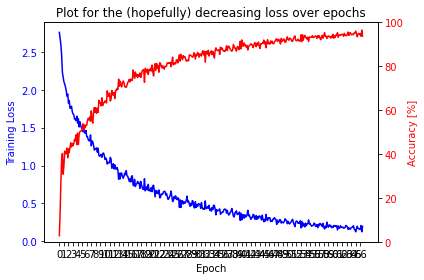

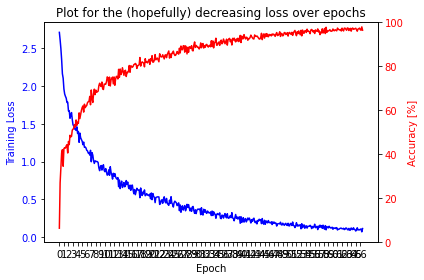

In [42]:
pltshow(lstmc)
pltshow(lstmc2)

In [44]:
eval(lstmc, chinese_test_loader)
eval(lstmc2, chinese_test_loader)

Test accuracy 84.8%
Test accuracy 85.5%


Bidirectional LSTM on Chinese data

In [45]:
train(bilstmc, 5, chinese_train_loader)
train(bilstmc2, 5, chinese_train_loader)

Epoch 0: 80batch [00:24,  3.30batch/s, accuracy=75, loss=0.755]
Epoch 1: 80batch [00:25,  3.12batch/s, accuracy=86.9, loss=0.398]
Epoch 2: 80batch [00:24,  3.24batch/s, accuracy=92.7, loss=0.214]
Epoch 3: 80batch [00:24,  3.26batch/s, accuracy=96.8, loss=0.103]
Epoch 4: 80batch [00:25,  3.19batch/s, accuracy=97.8, loss=0.0616]
Epoch 0: 80batch [00:24,  3.23batch/s, accuracy=78.6, loss=0.636]
Epoch 1: 80batch [00:25,  3.13batch/s, accuracy=90.6, loss=0.303]
Epoch 2: 80batch [00:25,  3.08batch/s, accuracy=96, loss=0.129]
Epoch 3: 80batch [00:25,  3.16batch/s, accuracy=98.3, loss=0.0601]
Epoch 4: 80batch [00:24,  3.21batch/s, accuracy=98.7, loss=0.0412]


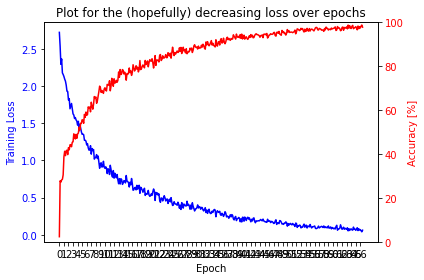

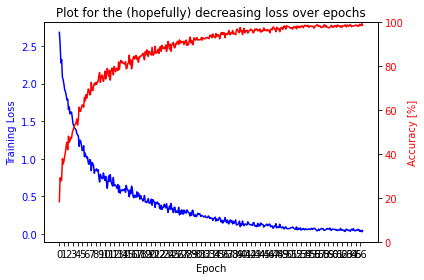

In [46]:
pltshow(bilstmc)
pltshow(bilstmc2)

In [47]:
eval(bilstmc, chinese_test_loader)
eval(bilstmc2, chinese_test_loader)

Test accuracy 86.4%
Test accuracy 85.2%


GRU on Chinese data

In [48]:
train(gruc, 5, chinese_train_loader)
train(gruc2, 5, chinese_train_loader)

Epoch 0: 80batch [00:06, 11.43batch/s, accuracy=72.1, loss=0.894]
Epoch 1: 80batch [00:06, 11.94batch/s, accuracy=81.4, loss=0.545]
Epoch 2: 80batch [00:06, 11.46batch/s, accuracy=88.9, loss=0.35]
Epoch 3: 80batch [00:07, 10.88batch/s, accuracy=92.4, loss=0.226]
Epoch 4: 80batch [00:06, 11.59batch/s, accuracy=95.3, loss=0.154]
Epoch 0: 80batch [00:07, 10.40batch/s, accuracy=75.7, loss=0.771]
Epoch 1: 80batch [00:07, 10.74batch/s, accuracy=86.2, loss=0.434]
Epoch 2: 80batch [00:07, 10.89batch/s, accuracy=92, loss=0.26]
Epoch 3: 80batch [00:07, 10.73batch/s, accuracy=95, loss=0.167]
Epoch 4: 80batch [00:07, 10.76batch/s, accuracy=96.7, loss=0.112]


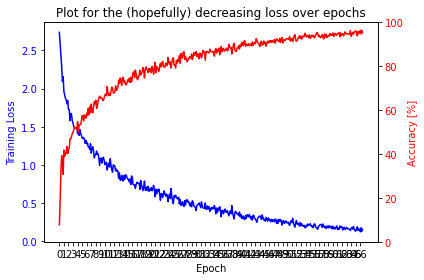

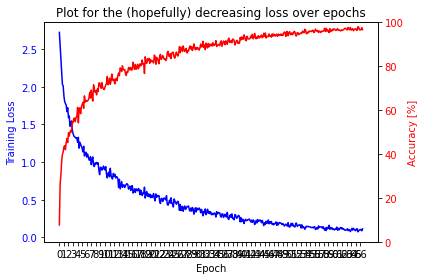

In [49]:
pltshow(gruc)
pltshow(gruc2)

In [52]:
eval(gruc, chinese_test_loader)
eval(gruc2, chinese_test_loader)

Test accuracy 85.2%
Test accuracy 83.8%


**Using UD Portuguese data**

In [63]:
batch_size = 50
portuguese_train_loader = DataLoader(dataset=portuguese_train, batch_size=50, 
                                 shuffle=True, collate_fn=collate)
portuguese_test_loader = DataLoader(dataset=portuguese_test, batch_size=50, 
                                shuffle=True, collate_fn=collate)

# create vocabulary for portuguese data
tokens = {token for sents,_ in portuguese_train_loader for sent in sents for token in sent}
idx2token = list(tokens)
idx2token.insert(0, '<UNK>')
idx2token.append('<PAD>')
token2idx = {token:idx for idx, token in enumerate(idx2token)}

tags = {tag for _,labels in portuguese_train_loader for tags in labels for tag in tags}
idx2tag = list(tags)
idx2tag.append('<PAD>')
tag2idx = {tag:idx for idx, tag in enumerate(idx2tag)}

print(idx2token[:15])
print(idx2tag)

['<UNK>', 'Americanas', 'Procuradoria', 'amada', 'Goytacaz', 'formou', 'Network', 'aquecimento', 'aldeamentos', 'Berdyev', 'Constância', 'cartéis', 'falado', 'concentrados', 'Phu']
['ADV', 'NUM', 'PUNCT', 'SYM', 'PROPN', 'X', 'DET', 'CCONJ', '_', 'ADJ', 'VERB', 'PRON', 'NOUN', 'AUX', 'PART', 'ADP', '<PAD>']


In [70]:
portuguese_train_loader = [pad_and_encode(sents, labels) for sents, labels in portuguese_train_loader]
portuguese_test_loader = [pad_and_encode(sents, labels) for sents, labels in portuguese_test_loader]

In [64]:
# create new models for Portuguese data

lstmp = LSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                  tagset_size=len(tag2idx)-1)
lstmp2 = LSTMTagger(word_embedding_dim=64, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                  tagset_size=len(tag2idx)-1)


bilstmp = BiLSTMTagger(word_embedding_dim=32, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)
bilstmp2 = BiLSTMTagger(word_embedding_dim=64, lstm_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)


grup = GRUTagger(word_embedding_dim=32, gru_hidden_dim=64, vocabulary_size=len(token2idx),
                     tagset_size=len(tag2idx)-1)
grup2 = GRUTagger(word_embedding_dim=64, gru_hidden_dim=64, vocabulary_size=len(token2idx),
                       tagset_size=len(tag2idx)-1)


Baseline LSTM model for Portuguese data

In [67]:
train(lstmp, 5, portuguese_train_loader)
train(lstmp2, 5, portuguese_train_loader)

Epoch 0: 194batch [00:23,  8.20batch/s, accuracy=85.5, loss=0.405]
Epoch 1: 194batch [00:23,  8.15batch/s, accuracy=92.5, loss=0.193]
Epoch 2: 194batch [00:23,  8.11batch/s, accuracy=97, loss=0.0932]
Epoch 3: 194batch [00:24,  7.94batch/s, accuracy=97.5, loss=0.0589]
Epoch 4: 194batch [00:23,  8.43batch/s, accuracy=99, loss=0.0495]
Epoch 0: 194batch [00:26,  7.45batch/s, accuracy=86.5, loss=0.377]
Epoch 1: 194batch [00:26,  7.27batch/s, accuracy=95, loss=0.154]
Epoch 2: 194batch [00:26,  7.39batch/s, accuracy=96.5, loss=0.0859]
Epoch 3: 194batch [00:25,  7.57batch/s, accuracy=97, loss=0.0649]
Epoch 4: 194batch [00:25,  7.51batch/s, accuracy=98.5, loss=0.0454]


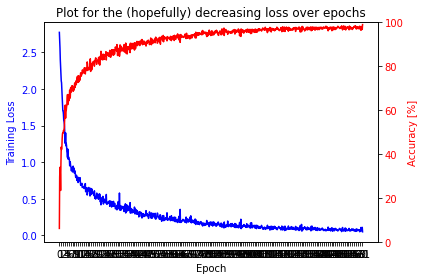

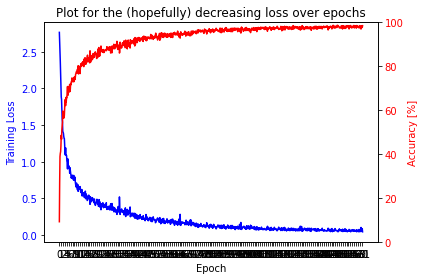

In [68]:
pltshow(lstmp)
pltshow(lstmp2)

In [71]:
eval(lstmp, portuguese_test_loader)
eval(lstmp2, portuguese_test_loader)

Test accuracy 92.5%
Test accuracy 91.3%


**Bidirectional LSTM on Portuguese data**

In [72]:
train(bilstmp, 5, portuguese_train_loader)
train(bilstmp2, 5, portuguese_train_loader)

Epoch 0: 194batch [01:10,  2.74batch/s, accuracy=89, loss=0.302]
Epoch 1: 194batch [01:13,  2.64batch/s, accuracy=98.5, loss=0.0728]
Epoch 2: 194batch [01:11,  2.71batch/s, accuracy=98.5, loss=0.0423]
Epoch 3: 194batch [01:11,  2.71batch/s, accuracy=99.5, loss=0.0188]
Epoch 4: 194batch [01:10,  2.73batch/s, accuracy=99.5, loss=0.0137]
Epoch 0: 194batch [01:13,  2.63batch/s, accuracy=90.5, loss=0.307]
Epoch 1: 194batch [01:13,  2.63batch/s, accuracy=97.5, loss=0.0822]
Epoch 2: 194batch [01:12,  2.69batch/s, accuracy=99.5, loss=0.0285]
Epoch 3: 194batch [01:14,  2.60batch/s, accuracy=99.5, loss=0.00879]
Epoch 4: 194batch [01:13,  2.66batch/s, accuracy=100, loss=0.00602]


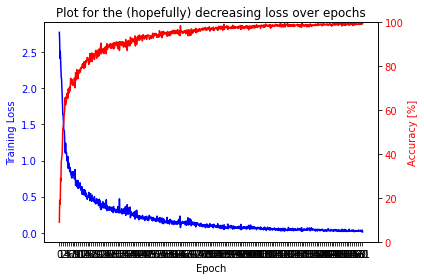

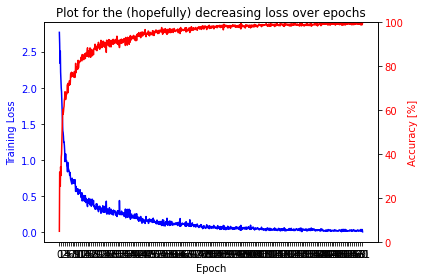

In [73]:
pltshow(bilstmp)
pltshow(bilstmp2)

In [74]:
eval(bilstmp, portuguese_test_loader)
eval(bilstmp2, portuguese_test_loader)

Test accuracy 93.7%
Test accuracy 93.6%


**GRU model on Portuguese data**

In [75]:
train(grup, 5, portuguese_train_loader)
train(grup2, 5, portuguese_train_loader)

Epoch 0: 194batch [00:20,  9.70batch/s, accuracy=83, loss=0.451]
Epoch 1: 194batch [00:19,  9.88batch/s, accuracy=91.5, loss=0.231]
Epoch 2: 194batch [00:19, 10.00batch/s, accuracy=95.5, loss=0.115]
Epoch 3: 194batch [00:19,  9.88batch/s, accuracy=97.5, loss=0.0641]
Epoch 4: 194batch [00:20,  9.64batch/s, accuracy=98, loss=0.0491]
Epoch 0: 194batch [00:23,  8.41batch/s, accuracy=88.5, loss=0.302]
Epoch 1: 194batch [00:21,  8.85batch/s, accuracy=96, loss=0.12]
Epoch 2: 194batch [00:22,  8.59batch/s, accuracy=98, loss=0.0722]
Epoch 3: 194batch [00:23,  8.28batch/s, accuracy=98.5, loss=0.0458]
Epoch 4: 194batch [00:22,  8.70batch/s, accuracy=99.5, loss=0.0334]


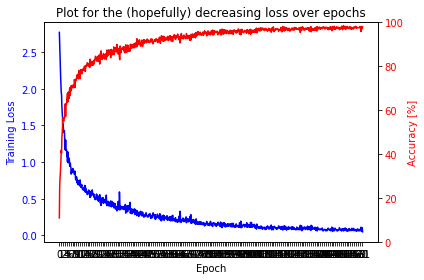

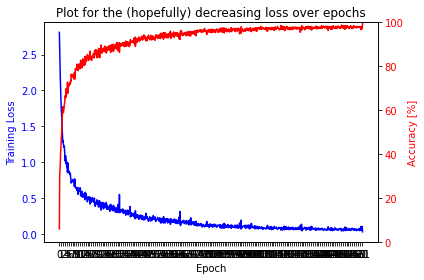

In [76]:
pltshow(grup)
pltshow(grup2)

In [77]:
eval(grup, portuguese_test_loader)
eval(grup2, portuguese_test_loader)

Test accuracy 92.2%
Test accuracy 91.0%
